# Financial Econometrics 2 - Project 2
## Matyáš Mattanelli & Jan Kubal

## Project 2 - Instructions

**Details:** Students are encouraged to form a group of two for project 2 which will be assigned in three small parts during the semester. Evaluation of this project will be during the final exam, when students will present and discuss their results.

### Part A:
Construct the TV-HAR model with tvOLS (or with any other function). Find the kernel bandwidth minimizing the MSE for the out-of-sample forecast for horizons 1, 5, and 22.

### Part B:
Estimate time-varying volatility of stock price time series (or an index) using the Stochastic volatility model. You can take the specification from lecture notes (Lecture 9), or you can define your own. For this task, you can use R package "stochvol" or you can use any other tool for state space models.

Perform also an out-of-sample forecast (horizon 1, 5, 22) and compare the forecasting performance with a GARCH family model of your choice.

### Part C:
Construct the TV-HAR model using the QBLL estimator. Compare the out-of-sample forecast performance with models in **Part A** of Project 2.

### Final: Fusion of Project 1 and Project 2:
Compare the prediction performance of all TV models in this project with the best neural network model from Project 1.

## Environment preparation

In [1]:
#Activate the environment
import Pkg
Pkg.activate(".")
#Pkg.instantiate() #In case the environment is activated for the first time

  Activating project at `d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1`


In [2]:
#Load packages
import CSV
import DataFrames
import Plots
import Dates
import MarketData
import Statistics
import ARCHModels
import StatsBase
import Flux
import Random
using LinearAlgebra
using Distributions

import RCall
RCall.R"library(tvReg)"
RCall.R"library(stochvol)"
RCall.R"library(rugarch)"

#Load auxilliary functions
include("utils.jl")

┌ Warning: RCall.jl: Loading required package: Matrix
│ Funded by the Horizon 2020. Framework Programme of the European Union.
│ 
└ @ RCall C:\Users\matya\.julia\packages\RCall\Wyd74\src\io.jl:172


┌ Warning: RCall.jl: Package stochvol 3.2.0 attached. To cite, see citation("stochvol").
└ @ RCall C:\Users\matya\.julia\packages\RCall\Wyd74\src\io.jl:172
┌ Warning: RCall.jl: Loading required package: parallel
│ 
│ Attaching package: 'rugarch'
│ 
│ The following object is masked from 'package:stats':
│ 
│     sigma
│ 
└ @ RCall C:\Users\matya\.julia\packages\RCall\Wyd74\src\io.jl:172


[> Loaded d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1\utils.jl


## Part A

In the first part we construct the time-varying HAR model (tvHAR) using the R package ``tvReg``, more specifically the ``tvLM`` function which is used to fit linear models with time-varying parameters. For this model, we find the kernel bandwidth minimizing the MSE for the out-of-sample forecast for horizons 1, 5, and 22. For each horizon *h* we estimate a different model, adjusting the dependent variable to capture the *h*-ahead average RV: $\frac{1}{h}\sum_{i=1}^h RV_{t+i}$

The underlying asset is VanEck Oil Services ETF (OIH), which is an ETF aiming to reflect the overall market performance of US oil industry-related firms. Five years (January 2012 to December 2017) of 1-minute intraday prices were acquired from [kibot.com](http://www.kibot.com/free_historical_data.aspx).

We start with loading the data and taking a look at the structure.

In [3]:
#Load data
data_OIH = CSV.read("OIH_adjusted_cut.csv", DataFrames.DataFrame; header=false);
data_OIH[1:5, :] #Take a peek at the data

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,String15,Time,Float64,Float64,Float64,Float64,Int64
1,01/03/2012,07:31:00,668.19,668.19,668.19,668.19,18
2,01/03/2012,08:00:00,648.82,648.82,648.82,648.82,35
3,01/03/2012,08:08:00,659.61,659.61,659.61,659.61,18
4,01/03/2012,09:01:00,662.71,662.71,662.71,662.71,159
5,01/03/2012,09:02:00,662.71,662.71,662.71,662.71,177


Next, we compute the daily Realized Variance and create the predictor variables for the HAR model. We also define the *h*-ahead average RV.

In [4]:
#Calculate RV 
RV = get_RV_from_kibot(data_OIH, returns_log = false)

#Compute HAR regressors
predictors = HAR_regressors(RV)
predictors = Float64.(predictors)

#Calculate the target for the horizon 1
target_1 = RV[23:end]
target_1 = Float64.(target_1);

#Calculate the target for horizons 5 and 22 (cumulative RV)
target_5 = [Statistics.mean(target_1[i:(i + 4)]) for i in range(1, size(target_1)[1] - 4)]
target_22 = [Statistics.mean(target_1[i:(i + 21)]) for i in range(1, size(target_1)[1]- 21)];

Now that the data is ready, we define a function estimating a single tvHAR model based on a single horizon and bandwidth. The function returns the MSE on the testing sample. Note that we set the parameter ``est`` of ``tvLM`` to "ll" in order to perform local linear estimation.

In [5]:
#Function for tvHAR estimation
function get_tvLM_MSE(bandwith; horizon = 1, predictors = predictors, target = target_1, kernel = "Triweight")
    #Separate the testing and training sample
    predictors_train = predictors[1:end-horizon, :] 
    predictors_test = predictors[end-horizon+1:end, :]
    target_train = target[1:end-horizon]
    target_test = target[end-horizon+1:end]
    #Estimate the model and forecast
    RCall.R""" 
    tv_ols <- tvLM($target_train ~ $(predictors_train[:, 1]) + $(predictors_train[:, 2]) + $(predictors_train[:, 3]), bw = $bandwith , est = 'll', tkernel = $kernel)
    preds <- forecast(tv_ols, $predictors_test, n.ahead = $horizon)
    #print(tv_ols$coefficients) #prints out the coefficients
    """

    preds = RCall.convert(Array{Float64}, RCall.R"preds") #Convert the predictions from R to Julia
    MSE = Statistics.mean((preds .- target_test).^2) #Calculate the MSE
    return MSE
end;

In the next step we define a helper function that loops through multiple bandwiths, estimates a model for each and returns their out of sample MSE.

In [16]:
#Function for finding the optimal bandwidth for a specific horizon
function get_best_bw(min_bw, max_bw, step; horizon = 1, predictors = predictors, target = target_1, kernel = "all", verbose = false, plot_mses = true)
    bws = collect(range(min_bw, max_bw, step = step)) #Specify the range of bandwidths
    if kernel == "all" #In case we want to loop through all kernels
        MSEs = zeros((length(bws), 3)) #One column for each kernel
        kernels = ["Triweight", "Epa", "Gaussian"] #Define the list of kernels
    else
        MSEs = zeros(length(bws)) #Empty array for the MSEs for each window
    end
    for idx in 1:length(bws) #Loop through the bandwidths
        if verbose #Print info if required
            println("window $window_size out of $max_wind for horizon $horizon") 
        end
        if kernel == "all"
            for kern in 1:3 #Loop through the kernels
                MSEs[idx, kern] = get_tvLM_MSE(bws[idx]; predictors = predictors, target = target, kernel = kernels[kern]) #Get MSE for given iteration
            end
        else
            MSEs[idx] = get_tvLM_MSE(bws[idx]; predictors = predictors, target = target, kernel = kernel) #Get MSE for given iteration
        end 
    end
    if plot_mses #Plot the bandwidths agains the MSEs if required
        if kernel == "all"
            Plots.plot(bws, MSEs[:, 1], label = kernels[1], xlab = "Bandwidth", ylab = "MSE", title = "Horizon $horizon")
            Plots.plot!(bws, MSEs[:, 2], label = kernels[2])
            display(Plots.plot!(bws, MSEs[:, 3], label = kernels[3]))
        else
            display(Plots.plot(bws, MSEs, legend = false, xlab = "Bandwidth", ylab = "MSE", title = "Horizon $horizon"))
        end
    end
    if kernel == "all"
        output = [bws[i] for i in mapslices(argmin, MSEs; dims = 1)[1, :]], mapslices(minimum, MSEs; dims = 1)[1, :] #Get the minimum for each kernel
        println("For horizon $horizon found optimum bandwidth $(output[1][argmin(output[2])]) with kernel $(kernels[argmin(output[2])]), MSE $(minimum(output[2]))")
        return output
    else        
        return bws[argmin(MSEs)], minimum(MSEs) #Return the best bandwidth along with its MSE
    end
end;

Now we can search through a range of bandwiths and find the one minimizing the out of sample MSE for each horizon.

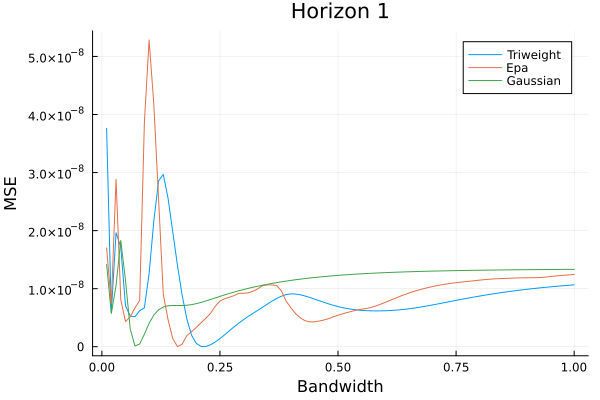

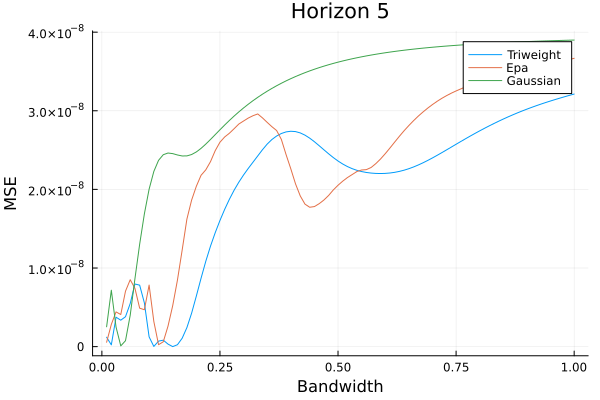

For horizon 1 found optimum bandwidth 0.16 with kernel Epa, MSE 2.172104490773912e-11

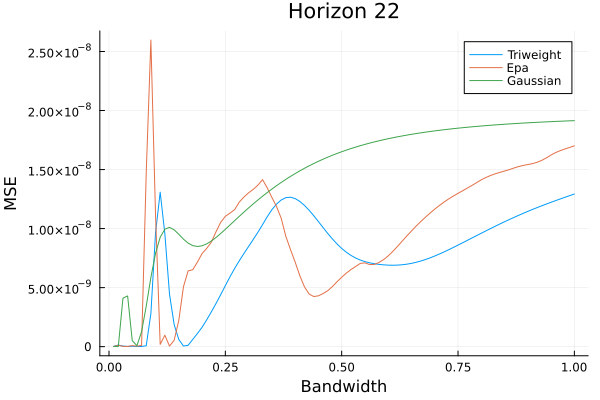


For horizon 5 found optimum bandwidth 0.15 with kernel Triweight, MSE 3.434712836799367e-12
For horizon 22 found optimum bandwidth 0.02 with kernel Gaussian, MSE 4.538000467335021e-12

In [17]:
#(runtime 16m)
#Horizon 1
optimum_hor_1 = get_best_bw(0.01, 1, 0.01)
#Horizon 5
optimum_hor_5 = get_best_bw(0.01, 1, 0.01; horizon = 5, predictors = predictors[begin:(end - 4), :], target = target_5)
#Horizon 22
optimum_hor_22 =  get_best_bw(0.01, 1, 0.01; horizon = 22, predictors = predictors[begin:(end - 21), :], target = target_22);

As we can see, we find the minimum for all horizons. The largest bandwith which minimizes the MSE is for horizon 1 while the lowest bandwidth is for horizon 22.

## Part B
In the second part of the project we estimate a Stochastic volatility model on the McDonald's stock price. We then compare the out of sample forecasts with a GARCH model.

We start by downloading the data from Yahoo Finance. We acquire 10 years worth of daily data (January 2012 - December 2021).

In [49]:
#Get daily returns
data_OIH_daily = DataFrames.combine(DataFrames.groupby(data_OIH, :Column1), last) #Extract the last observation for each day
data_OIH_daily_close = data_OIH_daily[:, 6] #Extract the adjusted close price
data_OIH_daily_rets = (data_OIH_daily_close[2:end] .- data_OIH_daily_close[1:end-1]) ./ data_OIH_daily_close[1:end-1]; #Calculate daily returns

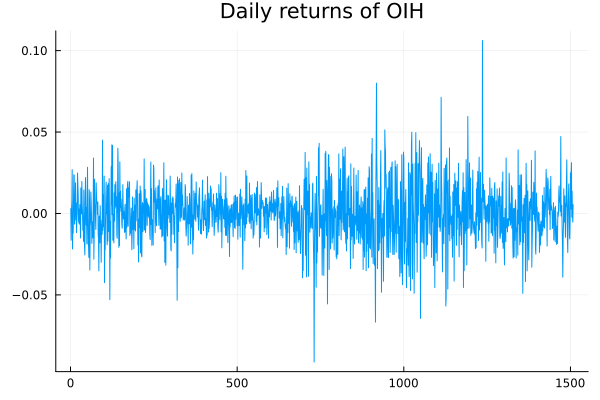

In [50]:
#Plot daily returns
Plots.plot(data_OIH_daily_rets, title = "Daily returns of OIH", legend = false)

In [12]:
# #Download data for McDonald's stock from Yahoo (42.2s)
# t1 = Dates.DateTime(2012, 1, 1) #Starting period
# t2 = Dates.DateTime(2022, 1, 1) #Ending period
# MCD = MarketData.yahoo("MCD", MarketData.YahooOpt(period1 = t1, period2 = t2));

In [34]:
#Temporary assignment
MCD_log_ret = data_OIH_daily_rets;

1508-element Vector{Float64}:
  0.002955223880597042
 -0.016399297598142775
  0.0025720164609052466
  0.006986991820843261
  0.02691483462962136
 -0.02175848230572779
 -0.003207327624787387
 -0.012077403133839251
  0.008543901108889272
  0.023762316750781137
  ⋮
  0.024954405942796073
  0.0026907386511587734
  0.024584487534626068
  0.031197194998310203
 -0.0023350607320619947
  0.013612006487773822
 -0.000769698197285792
 -0.005371766804508184
  0.005400778527319741

Next, we calculate the log-returns.

In [13]:
# #Store only the Adjusted Close price
# MCD_adj_close = MarketData.values(MCD[:AdjClose])

# #Calculate log-returns
# MCD_log_ret = diff(log.(MCD_adj_close));

For the stochastic volatility model, we need to specify the prior distribution of the parameters. For the level of log-variance of $\mu$, we choose to specify a slightly informative prior. Considering that we are working with daily log-returns, the unconditional variance on the log-scale usually lies around $\log(0.0001)\approx -9$ (Kastner, 2016). We verify this for our data below.

In [35]:
#Unconditional variace
println("Unconditional variance: $(Statistics.var(MCD_log_ret))")
println("Log of unconditional variance: $(log(Statistics.var(MCD_log_ret)))")

Unconditional variance: 0.0002998212175701437
Log of unconditional variance: -8.112324202384604


As can be seen, the value is indeed close to -9. Therefore, we will specify the mean and variance accordingly. Additionally, we need to specify the prior hyperparameters for the persistence of log-variance $\phi$. The prior is assumed to follow the beta distribution $\frac{\phi + 1}{2} \sim \Beta(\alpha, \beta)^*$ and thus the parameter $\alpha$ and $\beta$ need to be selected. Based on these parameters, the mean and variance of $\phi$ are then defined as follows:
$$
E(\phi) = \frac{2\alpha}{\alpha + \beta} - 1 \\
Var(\phi) = \frac{4\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}
$$
For smaller or homoskedastic data sets, the posterior distribution of the parameter may be almost entirely equal to the prior and thus it has to be selected with caution. We follow Kim *et al.* (1998) and select $\alpha = 20$ and $\beta = 1.5$. We also provide a demonstration of how different values of the parameters affect the mean and variance of $\phi$.

$^* \phi \in (-1,1)$ but the beta distribution assumes values between 0 and 1

In [36]:
#Function calculating mean and variance of the persistence parameter based on parameters α and β
function mean_var_phi(alpha, beta)
    mean_phi = (2 * alpha) / (alpha + beta) - 1
    var_phi = (4 * alpha * beta) / ((alpha + beta)^2 * (alpha + beta + 1))
    return mean_phi, var_phi
end;

In [37]:
#Mean and variance for a given choice of parameters
alpha, beta = 20, 1.5
println("For alpha = $alpha and beta = $beta, the mean of the persistence parameter is $(round(mean_var_phi(alpha,beta)[1],digits=3)) and its variance is $(round(mean_var_phi(alpha,beta)[2],digits=2))")

For alpha = 20 and beta = 1.5, the mean of the persistence parameter is 0.86 and its variance is 0.01


As we can see, the mean of the persistence parameter for our choice of prior is 0.86 and its variance is 0.01. In the next step we investigate how are these value influenced by the choice of $\alpha$ and $\beta$.

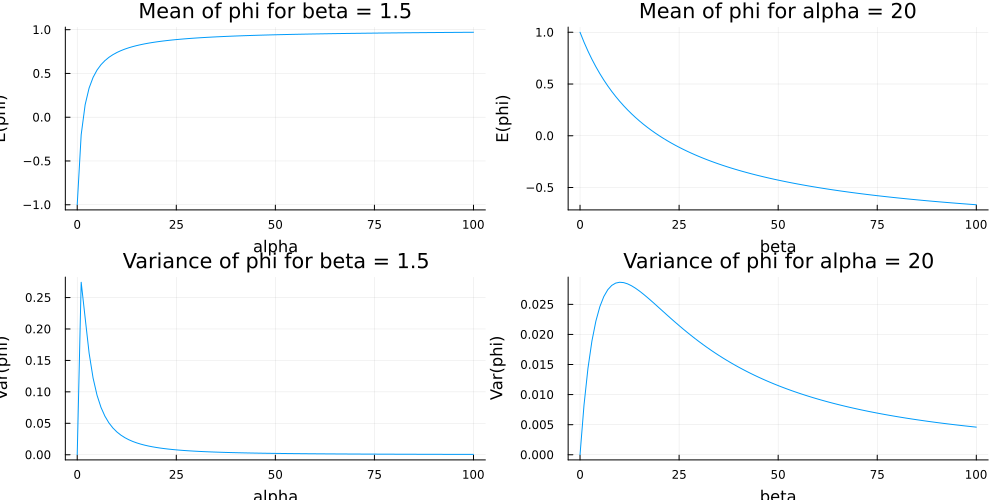

In [38]:
#Mean and variance of phi for different values of alpha and beta
alphas = 0:100 #Specify a range of alphas
betas = 0:100 #Specify a range of betas
means_phi_alphas = [mean_var_phi(i, beta)[1] for i in alphas] #Calculate means for all alphas and a fixed beta
vars_phi_alphas = [mean_var_phi(i, beta)[2] for i in alphas] #Calculate variances for all alphas and a fixed beta
means_phi_betas = [mean_var_phi(alpha, i)[1] for i in betas] #Calculate means for all alphas and a fixed beta
vars_phi_betas = [mean_var_phi(alpha,i )[2] for i in betas] #Calculate variances for all alphas and a fixed beta
plot_means_alphas = Plots.plot(alphas, means_phi_alphas, xlab = "alpha", ylab = "E(phi)", legend = false, title = "Mean of phi for beta = $beta")
plot_means_betas = Plots.plot(betas, means_phi_betas, xlab = "beta", ylab = "E(phi)", legend = false, title = "Mean of phi for alpha = $alpha")
plot_vars_alphas = Plots.plot(alphas, vars_phi_alphas, xlab = "alpha", ylab = "Var(phi)", legend = false, title = "Variance of phi for beta = $beta")
plot_vars_betas = Plots.plot(betas, vars_phi_betas, xlab = "beta", ylab = "Var(phi)", legend = false, title = "Variance of phi for alpha = $alpha")
Plots.plot(plot_means_alphas, plot_means_betas, plot_vars_alphas, plot_vars_betas, layout = 4, size = (1000, 500))


As the plots suggest, the $\alpha$ parameter seems to be a strong determinant of mean while the $\beta$ parameter has larger impact on variance. Lastly, we need to specify the prior for the volatility of log-variance. The choice of this parameter does not seem to have a large influence on the empirical results unless it is set too small. We can now proceed with the estimation.

In [39]:
#Estimation (2m)
MCD_log_ret_demeaned = MCD_log_ret .- Statistics.mean(MCD_log_ret) #Demeaning the log returns to avoid values very close to zero
RCall.R"""
set.seed(420) #Set seed for reproducibility
res <- svsample($MCD_log_ret_demeaned, priormu = c(-9, 1), priorphi = c(20, 1.5), priorsigma = 0.1, quiet = T)
vols <- vector("list", 3) #Empty vector to store the quantiles of the fitted volatilities
quants <- c(0.05, 0.5, 0.95) #Specify the quantiles
for (i in 1:3) { #Loop through the quantiles
    vols[[i]] <- apply(exp(res$latent[[1]]), 2, quantile, probs = quants[i]) #Store the given quantile of the exponentiated volatility
}
horizons <- c(1, 5, 22) #Specify the horizons
forecasts <- vector("list", 3) #Empty vector to store the forecasts
rets <- $MCD_log_ret_demeaned #Store the returns as an R variable
for (i in 1:3) { #Loop through the horizons
    res_hor <- svsample(rets[1:(length(rets) - horizons[i])], priormu = c(-9, 1), priorphi = c(20, 1.5), priorsigma = 0.1, quiet = T)
    forecasts[[i]] <- apply(as.matrix(predict(res_hor, horizons[i])[[1]][[1]]), 2, median) #Get the median of the predictions of returns
}
"""
preds = [RCall.convert(Array{Float64}, RCall.R"vols[[$i]]") for i in 1:3] #Convert the R list of fitted volatilities to a Julia array
forecasts = [RCall.convert(Array{Float64}, RCall.R"forecasts[[$i]]") for i in 1:3];  #Convert the R list of forecasts to a Julia array

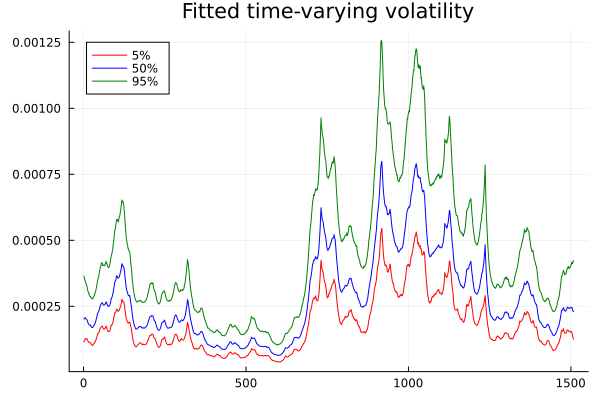

In [40]:
#Plot the fitted volatilities
Plots.plot(preds[1], label = "5%", title = "Fitted time-varying volatility", c = :red, legend = :topleft)
Plots.plot!(preds[2], c = :blue, label = "50%")
Plots.plot!(preds[3], c = :green, label = "95%")

Above we provide the 5th, 50th, and 90th quantile of the fitted volatility. For the sake of comparison of forecast performance, we also estimate a GARCH model (the optimal parameters for the underlying series were found in Project 1).

In [41]:
#Estimate GARCH
spec = ARCHModels.GARCH{1, 1}([0, .1, .08]) #Define the specifications and choose intial values for the coefficients
MCD_garch = ARCHModels.UnivariateARCHModel(spec, MCD_log_ret_demeaned; dist = ARCHModels.StdT(3.), meanspec = ARCHModels.AR{1}([0,-.1])) #Specify the model
ARCHModels.fit!(MCD_garch) #Fitting the model


GARCH{1, 1} model with Student's t errors, T=1508.

Mean equation parameters:
───────────────────────────────────────────────────
        Estimate    Std.Error     z value  Pr(>|z|)
───────────────────────────────────────────────────
c    0.000315858  0.000375257   0.841712     0.3999
φ₁  -0.00129765   0.0261896    -0.0495485    0.9605
───────────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   1.08403e-6  8.18446e-7   1.32449    0.1853
β₁  0.960181    0.0126112   76.1374     <1e-99
α₁  0.0365083   0.0114269    3.19496    0.0014
──────────────────────────────────────────────

Distribution parameters:
─────────────────────────────────────────
   Estimate  Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────
ν   10.5592    2.91069  3.62772    0.0003
─────────────────────────────────────────


As can be seen, all the coefficients are statistically signifiant. We can now compare the fitted volatilities between the models.

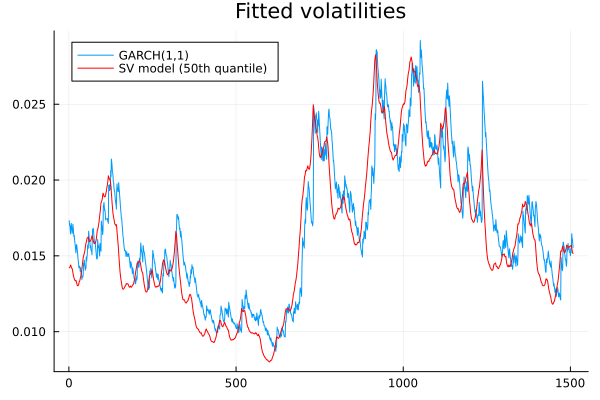

In [42]:
#Plot GARCH fitted volatility
Plots.plot(ARCHModels.volatilities(MCD_garch), title = "Fitted volatilities", label = "GARCH(1,1)", legend = :topleft)
Plots.plot!(sqrt.(preds[2]), label = "SV model (50th quantile)", c =:red)

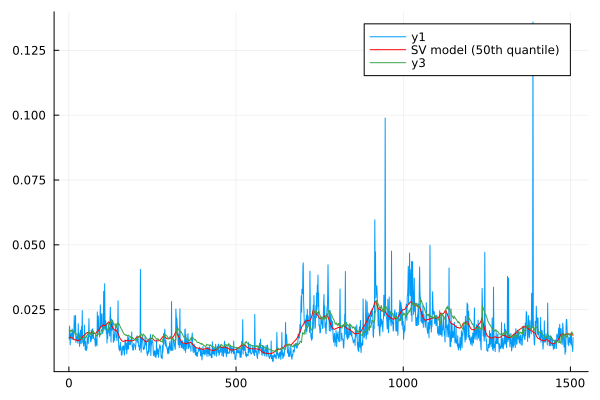

In [51]:
Plots.plot(sqrt.(RV[2:end]))
Plots.plot!(sqrt.(preds[2]), label = "SV model (50th quantile)", c =:red)
Plots.plot!(ARCHModels.volatilities(MCD_garch))

The stochastic volatility model appears to estimate volatility slightly lower in magnitude. We will see what will be the effect on the ability to predict returns. Since we struggled to get the n-step ahead forecasts using the ``ARCHModels`` package in Julia, we perform the predicting using the R ``rugarch`` package instead.

In [48]:
#GARCH forecasts
RCall.R"""
horizons <- c(1, 5, 22) #Specify the horizons
forecasts_garch <- vector("list", 3) #Empty vector for the forecasts
garchspec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), 
                        mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), distribution.model = "std") #Specification
log_rets <- $MCD_log_ret_demeaned #Store the log returns in R
for (i in 1:3) { #Loop through horizons
    garch_fit <- ugarchfit(garchspec, log_rets[1:(length(log_rets) - horizons[i])], solver = "hybrid") #Fit for each horizon
    forec <- ugarchforecast(garch_fit, n.ahead = horizons[i]) #Forecast
    forecasts_garch[[i]] <- as.numeric(sigma(forec)) #Store the forecasts
}
"""
forecasts_garch = [RCall.convert(Array{Float64}, RCall.R"forecasts_garch[[$i]]") for i in 1:3]; #Convert R list to Julia array

Since we want to compare the forecasting performance of the two models, we need to compare the predictions to some measure of volatility. We obviously do not have the true volatility at our disposal and therefore we opt for the Realized Volatility. However, we do not have the intraday returns either and therefore we have to estime RV in another way. We use the High Low Range proxy inroduced by Parkinson (1980) which is defined as
$$
RV_t = ln\left(\frac{H_t}{L_t}\right)
$$,
where $H_t$ is the daily high price at time $t$ and $L_t$ is the daily low price at time $t$. This proxy should be less noisy than squaring daily returns.

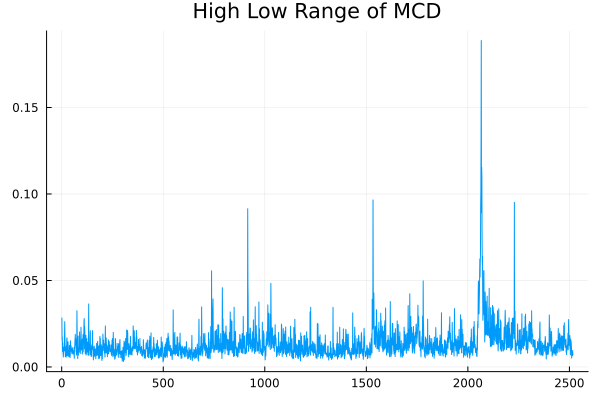

In [48]:
# #Calculate a prox for RV
# HLR = log.(MarketData.values(MCD[:High]) ./ MarketData.values(MCD[:Low]))
# Plots.plot(HLR, title = "High Low Range of MCD", legend = false)

Now that we have the forecasts and the proxy, we can calculate the MSE and MAE for each horizon and each model and compare them.

In [52]:
#Calculate MSEs and MAEs
horizons = [1, 5, 22] #Specify the horizons
MSEs_stvol = zeros(3) #Empty vector for the MSEs of the stochastic volatility model
MSEs_garch = zeros(3) #Empty vector for the MSEs of the GARCH model
MAEs_stvol = zeros(3) #Empty vector for the MAEs of the stochastic volatility model
MAEs_garch = zeros(3) #Empty vector for the MAEs of the GARCH model
for i in 1:3 #Loop through horizons
    MSEs_stvol[i] = Statistics.mean((forecasts[i] .- RV[(end - horizons[i] + 1):end]).^2) #Calculate the MSE for the given horizon
    MSEs_garch[i] = Statistics.mean((forecasts_garch[i] .- RV[(end - horizons[i] + 1):end]).^2) #Calculate the MSE for the given horizon
    MAEs_stvol[i] = Statistics.mean(abs.(forecasts[i] .- RV[(end - horizons[i] + 1):end])) #Calculate the MAE for the given horizon
    MAEs_garch[i] = Statistics.mean(abs.(forecasts_garch[i] .- RV[(end - horizons[i] + 1):end])) #Calculate the MAE for the given horizon
end

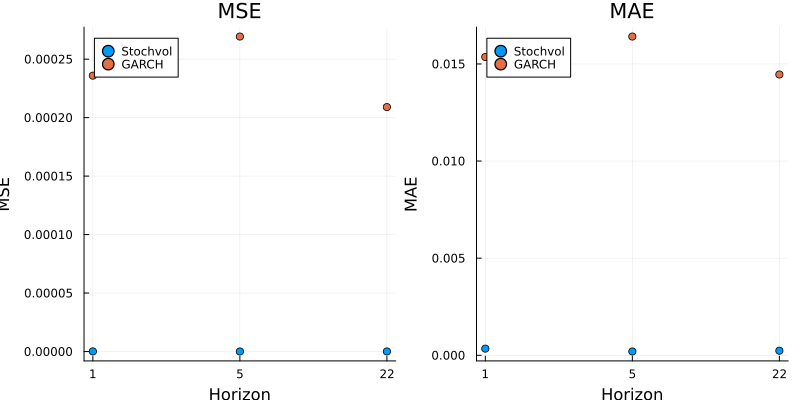

In [53]:
#Plot MSEs and MAEs
MSE_plot = Plots.plot(MSEs_stvol, title = "MSE", seriestype = :scatter, legend = :topleft, label = "Stochvol", xlab = "Horizon", ylab = "MSE", xticks = ([1, 2, 3], horizons))
MSE_plot = Plots.plot!(MSEs_garch, seriestype = :scatter, label = "GARCH")
MAE_plot = Plots.plot(MAEs_stvol, title = "MAE", seriestype = :scatter, legend = :topleft, label = "Stochvol", xlab = "Horizon", ylab = "MAE", xticks = ([1, 2, 3], horizons))
MAE_plot = Plots.plot!(MAEs_garch, seriestype = :scatter, label = "GARCH")
Plots.plot(MSE_plot, MAE_plot, size = (800, 400))

As we can see, the Stochastic Volatility model outperforms the GARCH in all horizons and both for MSE and MEA.

## Part C

Here we estimate the TV-HAR again, this time using the QBLL estimator. We will perform out-of-sample forecasts for horizons 1, 5, and 22, and compare the MSE with the results for the optimal bandwith from Part A. We will again use the Realized Volatilitiy data computed from OIH intraday returns between Jan 2012 and Dec 2017.

In [6]:
#we can work with data prepared for part A
println(size(predictors), size(target_1), size(target_5), size(target_22))

(1487, 3)(1487,)(1483,)(1466,)


First, we need to define function producing the matrix of kernel weights.

In [7]:
function kernel_weights(T, H)
    ww = zeros(T, T)
    for j in 1:T
      for i in 1:T
        z = (i - j)/H
        ww[i,j] = (1.0 / sqrt(2.0 * pi)) * exp((-1.0 / 2.0) * (z * z))  # Normal
        #ww[i,j] = (2.0 / pi ) * (1.0 / (exp(z) + exp(-z))) # sigmoid
        #ww[i,j] = 1.0 / (exp(z)+2.0+exp(-z)) # Logistic
        #ww[i,j] = 1.0 - abs(z)  # traingular
        #ww[i,j] = (3.0/4.0)*(1.0-(z * z)) # epan
      end     
    end 
  
    s = sum(ww, dims=2)
    adjw = zeros(T, T)  
  
    for k in 1:T
      adjw[k, :] = ww[k, :] / s[k]
    end
  
    cons = sum(adjw .^ 2.0, dims = 2)
  
    for k in 1:T
      adjw[k, :] = (1.0 / cons[k]) * (adjw[k, :])
    end
  
    return adjw
  end;

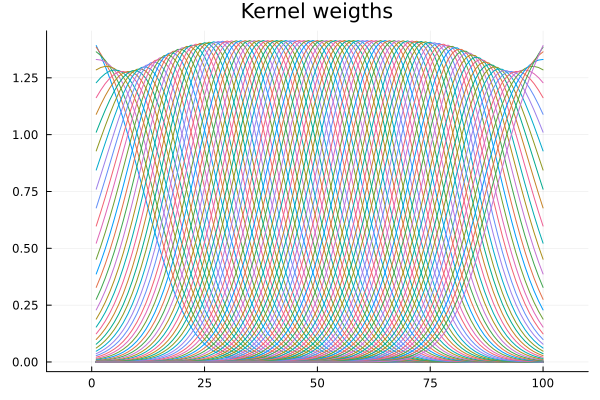

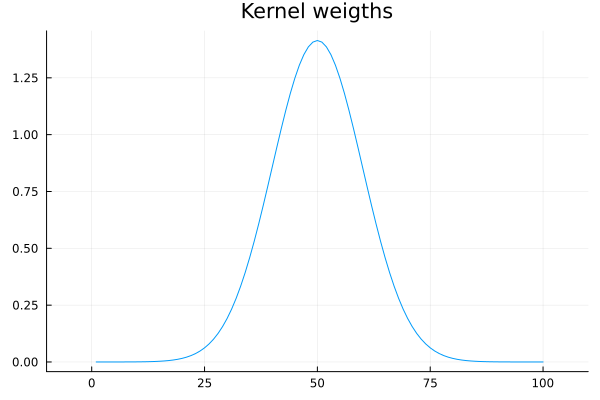

In [8]:
#Example use of weights, can be removed:
weights=kernel_weights(100,10)
display(Plots.plot(xlim=(-10,110),weights, label=false,  title="Kernel weigths"))
display(Plots.plot(xlim=(-10,110),weights[50,:], label=false,  title="Kernel weigths"))

The time varying HAR can be estimated by QBLL estimator using the ``TVP_QBLL``, which was created following Petrova(2019) and example from Lecture 10.

In [9]:
function TVP_QBLL(y, x, Nsim::Int, H::Int)
    T=size(y,1)
    k=size(x,2)
    x=[ones(T) x] #should we have intercept??

    #USE full sample OLS estimates as priors...
    b01=x\y #b01 = inverse(x)*y
    e=y-x*b01 # e = y - x * (inverse(x)*y)
    s2=e'*e/(T-k) 
    # diagonal elements of this are the scale parameter of Gamma distribution. Let's call them gamma0.

    #here the base values of posterior parameters are defined - I dont know why like this, not explained in Lecture nor appendix. Perhaps Petrova2019?
    g0=1/s2 #s2 - float
    k0=1/s2*inv(x'*x)
    a0=max(k+2,k+2*8-T)
    g0=(a0-k-1)*g0
    
    #computing kernel weights
    weights=kernel_weights(T,H)

    # define storage for betas and lambdas
    beta=zeros(T,1+k);
    w = zeros(T,1)
    bayesprec, bayessv = zeros(k+1,k+1), zeros(k+1,k+1)
    BB = zeros(k+1)
    bayesalpha, g1, g2, g3, bayesgamma = 0.0, 0.0, 0.0, 0.0, 0.0

    
    for ii in 1:T
        B1=zeros(k+1,Nsim)
        w=weights[ii,:]
        bayesprec=k0+x'*Diagonal(w)*x #D.49 k_s
        bayessv=inv(bayesprec)
        BB=bayessv*((x'*Diagonal(w))*y+k0*b01) #D.48 L #isnt here mistake, shouldnt be instead of y beta_s hat?
        bayesalpha=a0+sum(w)/2 #D.50

        g1=b01'*k0*b01 #D.51
        g2=y'*Diagonal(w)*y #D.51
        g3=BB'*bayesprec*BB #D.51
        bayesgamma=g0+0.5*(g1+g2-g3) #D.51
        
        # Sampling from Gamma and Normal distribution
        for ll=1:Nsim
            B1[:,ll]=BB+cholesky(Symmetric(bayessv).*1.0).U'*randn(k+1)*sqrt(rand(Gamma(bayesalpha,1/bayesgamma)));
        end

        for i in 1:k+1
            beta[ii,i] = quantile(B1[i,:],0.5) # getting the betas
        end

    end
    
    return beta
end;

In [10]:
#Defining other parameters
Nsim = 1000; #Number of simulations? in Petrova2019 I = 1000
H = floor(sqrt(size(predictors, 1))) #parameter - chosen randomly? in Petrova2019 H = T^1/2 where T is size of y
H = Int.(H);

In [11]:
#estimating betas by QBLL estimator
betas = TVP_QBLL(target_1,predictors,Nsim,H);
betas[end,:] #the last coefficients, to be used for predictions

4-element Vector{Float64}:
 9.366612820017826e-5
 0.03884727151401666
 0.17011492468333134
 0.45886064798493315

The estimated parameters produced by QBLL estimator are close to constant, their values change marignally, but a there is present a pattern.

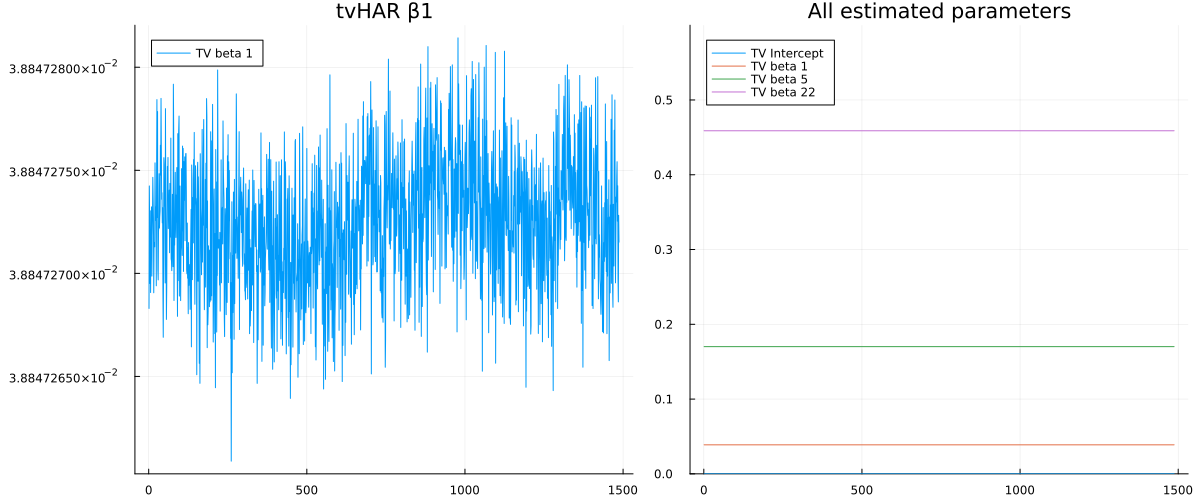

In [12]:
plot_all_b = Plots.plot(ylims=(0,0.6), [betas[:,1] betas[:,2] betas[:,3] betas[:,4]] ,label=["TV Intercept" "TV beta 1" "TV beta 5" "TV beta 22"],legend = :topleft, title = "All estimated parameters")
plot_b1 = Plots.plot(betas[:,2],label="TV beta 1",legend = :topleft, title = "tvHAR β1")

Plots.plot(plot_b1, plot_all_b, layout = 2, size = (1200, 500))

We compute the Mean Squared Error of out-of-sample predictions for horizons 1, 5, and 22, same as in Part A.

In [13]:
#Defining function for making the n-ahead prediction and getting MSE
function get_QBLL_MSE(target, predictors, Nsim, H, horizon)
    horizon = 1 #due to the averaging of the output
    #Separate the testing and training sample
    predictors_train = predictors[1:end-horizon, :] 
    predictors_test = predictors[end-horizon+1:end, :]
    target_train = target[1:end-horizon]
    target_test = target[end-horizon+1:end]

    #Estimate the model and forecast
    betas = TVP_QBLL(target_train, predictors_train, Nsim, H);
    last_coef = betas[end,:] #incorporating the note from workshop    
    MSE = 0

    for i in 1:horizon
        pred = last_coef[1] + sum(last_coef[2:end] .* predictors_test[i,:]) # b0 + x*b - follows D.37 in Apendix from L10
        #println((pred - target_test[i])^2 / horizon)
        MSE += (pred - target_test[i])^2 / horizon
    end

    #println("Horizon: $horizon, QBLL MSE: $MSE")
    return MSE
end;

In [24]:
#The QBLL TV-HAR MSE for horizons 1,5,22:
QBLL_MSE_hor_1 = get_QBLL_MSE(target_1,predictors,Nsim,H,1)
QBLL_MSE_hor_5 = get_QBLL_MSE(target_5,predictors[begin:(end - 4), :],Nsim,H,5)
QBLL_MSE_hor_22 = get_QBLL_MSE(target_22,predictors[begin:(end - 21), :],Nsim,H,22);

Bellow is the comaprison of the Mean Squared Error on out-of-sample forecasts for horizons 1, 5, and 22, based on bot tvOLS and tvQBLL estimators. For all three horizons the OLS estimator prudces MSE smaller by one or two orders of magnitude.

In [25]:
#Comparison
println("The best MSE achieved")
println("Horizon 1, tvOLS: $(minimum(optimum_hor_1[2])), tvQBLL: $QBLL_MSE_hor_1")
println("Horizon 5, tvOLS: $(minimum(optimum_hor_5[2])), tvQBLL: $QBLL_MSE_hor_5")
println("Horizon 22, tvOLS: $(minimum(optimum_hor_22[2])), tvQBLL: $QBLL_MSE_hor_22")


The best MSE achieved
Horizon 1, tvOLS: 2.172104490773912e-11, tvQBLL: 3.310747639278188e-10
Horizon 5, tvOLS: 3.434712836799367e-12, tvQBLL: 1.2297613231809346e-8
Horizon 22, tvOLS: 4.538000467335021e-12, tvQBLL: 9.770990349807354e-10


## Part D - Fusion of Project 1 and Project 2
In this part, we compare the performance of models described in this project with the best NN model from Project 1.

In Project 1, we split the data on training and testing samples, instead of selecting a prediction horizon, therefore the models are not directly comparable. We will therefore use the functions from project one to find optimal parameters of the NN model and compare the time varting model with performance of this model.

In [207]:
function train_test_split_tv(predictors, target) #this function returns data ready to be fed into NN - split and standardized
    X_train = predictors[1:end-1, :] |> permutedims .|> Float32
    X_test = predictors[end, :] |> permutedims .|> Float32

    y_train = target[1:end-1, :] |> permutedims .|> Float32
    y_test = target[end, :] |> permutedims .|> Float32

    #mean_X_train = mapslices(StatsBase.mean, X_train; dims = 2) #Save the mean
    #std_X_train = mapslices(StatsBase.std, X_train; dims = 2) #Save the standard deviation
    X_train = standardize_tv(X_train, X_test, true) #Standardize the training set (using a custom define function from utils)
    X_test = standardize_tv(X_train, X_test, false); #Standardize the testing set (using mean and std of the training set)
    
    return X_train, X_test, y_train, y_test
end

train_test_split_tv (generic function with 2 methods)

Due to the way the target is averaged for each horizon, we do separate grid searches for Neural Networks and Recurent Neural Networks for each horizon separately.

### NN and RNN - Horizon 1

In [208]:
X_train, X_test, y_train, y_test = train_test_split_tv(predictors, target_1);


In [209]:
#Perform grid search (29s)
param_grid = Dict(:nodes => [3, 7, 10], :learn_rate => [0.01, 0.1, 0.3], :α => [0, 0.1, 1], :dropout => [0, 0.2, 0.5], :opt => [Flux.Descent, Flux.Adam], :activ_func => [Flux.relu, Flux.tanh, Flux.sigmoid]) #Specify the parameter grid
gridsearch_res = gridSearch(param_grid, X_train, y_train, X_test |> permutedims, y_test; verbose = false);

In [210]:
MSE_NN_1 = DataFrames.sort(gridsearch_res, :MSE)[1,end]
DataFrames.sort(gridsearch_res, :MSE)[begin:5,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,0.1,Descent,3,0.01,0.0,σ,1.11757e-11
2,0.0,Descent,3,0.3,0.0,σ,7.71551e-11
3,1.0,Descent,7,0.1,0.5,σ,9.95649e-11
4,1.0,Descent,3,0.3,0.2,σ,1.55608e-10
5,1.0,Descent,3,0.3,0.0,σ,1.70138e-10


In [211]:
#The grid search for RNN(15m)
X_train_RNN = reshape(X_train, 3, 1, :) #Reshaping to accomodate the syntax of Flux RNN
y_train_RNN = reshape(y_train, 1, 1, :) #Reshaping to accomodate the syntax of Flux RNN
X_test_RNN = reshape(X_test, 3, 1, :) #Reshaping to accomodate the syntax of Flux RNN
y_test_RNN = reshape(y_test, 1, 1, :) #Reshaping to accomodate the syntax of Flux RNN
gridsearch_RNN_res = gridSearch(param_grid, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN; verbose = false, func = train_RNN);

In [212]:
#Show best 5 models
MSE_RNN_1 = DataFrames.sort(gridsearch_RNN_res, :MSE)[1,end]
DataFrames.sort(gridsearch_RNN_res, :MSE)[begin:5,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,1.0,Descent,3,0.3,0.5,σ,5.42508e-14
2,1.0,Descent,10,0.1,0.2,relu,1.90468e-13
3,1.0,Descent,3,0.1,0.2,σ,9.76465e-13
4,1.0,Descent,7,0.1,0.2,σ,1.10502e-12
5,1.0,Descent,3,0.1,0.2,tanh,3.00708e-12


### NN and RNN - Horizon 5

In [213]:
X_train, X_test, y_train, y_test = train_test_split_tv(predictors, target_5);


In [214]:
param_grid = Dict(:nodes => [3, 7, 10], :learn_rate => [0.01, 0.1, 0.3], :α => [0, 0.1, 1], :dropout => [0, 0.2, 0.5], :opt => [Flux.Descent, Flux.Adam], :activ_func => [Flux.relu, Flux.tanh, Flux.sigmoid]) #Specify the parameter grid
gridsearch_res = gridSearch(param_grid, X_train[:, begin:(end - 4)], y_train, X_test |> permutedims, y_test; verbose = false);

In [215]:
MSE_NN_5 = DataFrames.sort(gridsearch_res, :MSE)[1,end]
DataFrames.sort(gridsearch_res, :MSE)[begin:5,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,1.0,Descent,7,0.01,0.2,σ,2.4506e-11
2,0.1,Descent,3,0.01,0.0,σ,2.88654e-11
3,0.0,Descent,3,0.3,0.0,σ,4.51997e-11
4,1.0,Descent,7,0.1,0.5,tanh,3.22728e-10
5,1.0,Descent,7,0.3,0.0,relu,3.35936e-10


In [216]:
X_train_RNN = reshape(X_train, 3, 1, :) #Reshaping to accomodate the syntax of Flux RNN
y_train_RNN = reshape(y_train, 1, 1, :) #Reshaping to accomodate the syntax of Flux RNN
X_test_RNN = reshape(X_test, 3, 1, :) #Reshaping to accomodate the syntax of Flux RNN
y_test_RNN = reshape(y_test, 1, 1, :) #Reshaping to accomodate the syntax of Flux RNN
gridsearch_RNN_res = gridSearch(param_grid, X_train_RNN[:,:,begin:(end - 4)], y_train_RNN, X_test_RNN, y_test_RNN; verbose = false, func = train_RNN);

In [217]:
#Show best 5 models
MSE_RNN_5 = DataFrames.sort(gridsearch_RNN_res, :MSE)[1,end]
DataFrames.sort(gridsearch_RNN_res, :MSE)[begin:5,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,1.0,Descent,7,0.3,0.5,relu,1.63474e-11
2,1.0,Descent,3,0.3,0.2,tanh,2.5765e-11
3,1.0,Descent,3,0.3,0.0,tanh,3.62514e-11
4,1.0,Descent,3,0.1,0.0,σ,4.05011e-11
5,1.0,Descent,10,0.3,0.0,tanh,7.26033e-11


### NN and RNN - Horizon 22

In [218]:
X_train, X_test, y_train, y_test = train_test_split_tv(predictors, target_22);

In [219]:
param_grid = Dict(:nodes => [3, 7, 10], :learn_rate => [0.01, 0.1, 0.3], :α => [0, 0.1, 1], :dropout => [0, 0.2, 0.5], :opt => [Flux.Descent, Flux.Adam], :activ_func => [Flux.relu, Flux.tanh, Flux.sigmoid]) #Specify the parameter grid
gridsearch_res = gridSearch(param_grid, X_train[:, begin:(end - 21)], y_train, X_test |> permutedims, y_test; verbose = false);

In [220]:
MSE_NN_22 = DataFrames.sort(gridsearch_res, :MSE)[1,end]
DataFrames.sort(gridsearch_res, :MSE)[begin:5,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,1.0,Descent,7,0.1,0.5,σ,1.43294e-12
2,0.1,Descent,3,0.01,0.0,σ,1.19402e-11
3,1.0,Descent,7,0.01,0.0,σ,4.7163e-11
4,1.0,Descent,7,0.1,0.2,σ,4.89109e-11
5,1.0,Descent,7,0.1,0.0,σ,6.44294e-11


In [221]:
X_train_RNN = reshape(X_train, 3, 1, :) #Reshaping to accomodate the syntax of Flux RNN
y_train_RNN = reshape(y_train, 1, 1, :) #Reshaping to accomodate the syntax of Flux RNN
X_test_RNN = reshape(X_test, 3, 1, :) #Reshaping to accomodate the syntax of Flux RNN
y_test_RNN = reshape(y_test, 1, 1, :) #Reshaping to accomodate the syntax of Flux RNN
gridsearch_RNN_res = gridSearch(param_grid, X_train_RNN[:,:,begin:(end - 21)], y_train_RNN, X_test_RNN, y_test_RNN; verbose = false, func = train_RNN);

In [222]:
#Show best 5 models
MSE_RNN_22 = DataFrames.sort(gridsearch_RNN_res, :MSE)[1,end]
DataFrames.sort(gridsearch_RNN_res, :MSE)[begin:5,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,1.0,Descent,10,0.1,0.0,σ,1.20847e-13
2,1.0,Descent,10,0.1,0.5,tanh,8.48867e-13
3,1.0,Descent,3,0.3,0.2,σ,1.71219e-12
4,1.0,Descent,3,0.1,0.5,σ,2.39033e-12
5,1.0,Descent,3,0.1,0.2,relu,3.36401e-12


In [223]:
#Comparison
println("The best MSE achieved")
println("Horizon 1, tvOLS: $(minimum(optimum_hor_1[2])), tvQBLL: $QBLL_MSE_hor_1, NN: $MSE_NN_1, RNN: $MSE_RNN_1")
println("Horizon 5, tvOLS: $(minimum(optimum_hor_5[2])), tvQBLL: $QBLL_MSE_hor_5, NN: $MSE_NN_5, RNN: $MSE_RNN_5")
println("Horizon 22, tvOLS: $(minimum(optimum_hor_22[2])), tvQBLL: $QBLL_MSE_hor_22, NN: $MSE_NN_22, RNN: $MSE_RNN_22")

The best MSE achieved
Horizon 1, tvOLS: 2.172104490773912e-11, tvQBLL: 3.310747639278188e-10, NN: 1.1175726143120013e-11, RNN: 5.4250772982007006e-14
Horizon 5, tvOLS: 3.434712836799367e-12, tvQBLL: 1.2297613231809346e-8, NN: 2.450604302817183e-11, RNN: 1.6347397394089747e-11
Horizon 22, tvOLS: 4.538000467335021e-12, tvQBLL: 9.770990349807354e-10, NN: 1.4329408970156776e-12, RNN: 1.2084711215661764e-13


The comparison of all tvHAR models with HAR predicted via NN and RNN shows that Recurrent Neural Networks achieve the lowest MSE for Hrozons 1 and 22, while for h = 5 the best model seems to be tvOLS HAR. The Bayesian method tvQBLL seems to produce the worst results in terms of MSE.

### References

- Parkinson, M. (1980). The Extreme Value Method for Estimating the Variance of the Rate of Return. The Journal of Business, 53(1), 61–65. http://www.jstor.org/stable/2352357

- Petrova, K. (2019). A quasi-Bayesian local likelihood approach to time varying parameter VAR models. Journal of Econometrics, 212(1), 286-306. https://doi.org/10.1016/j.jeconom.2019.04.031